<a href="https://colab.research.google.com/github/ncorriveau/ood_computervision/blob/main/Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Packages

In [ ]:
import torch
from torch import nn
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np 
import pandas as pd
import os
from pathlib import Path
import random
from PIL import Image
from matplotlib import pyplot as plt
import requests
import zipfile
import shutil

#put on gpu if available 
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#Mount drive and set paths

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = '/content/drive/MyDrive/NN and DL/projects/Released_Data/train'
test_path = '/content/drive/MyDrive/NN and DL/projects/Released_Data/test'

#Data Augmentation and Preparation 

This part assumes that you have already run the data preprocess notebook and have the train and test folders in a format of:
train/superclass/subclass and test/supeclass/subclass

In [ ]:
train_transforms = train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.RandomGrayscale(0.5),
    #transforms.RandomAdjustSharpness(2, 0.5), # adjust sharpness by a factor of 2 with prob 0.5 of it being adjusted
    transforms.RandomInvert(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # change intensity of image with max being 31 
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])


In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """

    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

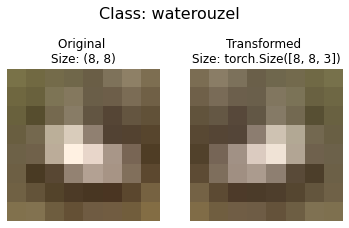

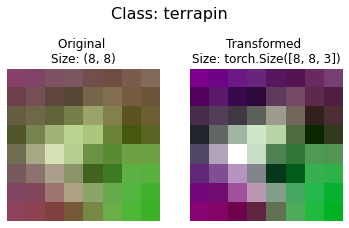

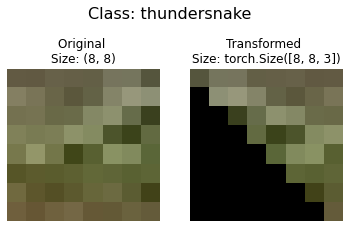

In [ ]:
#this returns a posix path to every image in our training directory 
image_paths = list(Path(train_path).glob("*/*/*.jpg"))

plot_transformed_images(image_paths, 
                        transform=train_transforms, 
                        n=3)

In [ ]:
from torchvision import datasets
train_data_super_class = datasets.ImageFolder(root=train_path, transform=train_transforms)
train_data_sub_class_dog = datasets.ImageFolder(root=train_path+'/dog', transform=train_transforms)
train_data_sub_class_reptile = datasets.ImageFolder(root=train_path+'/reptile', transform=train_transforms)
train_data_sub_class_bird = datasets.ImageFolder(root=train_path+'/bird', transform=train_transforms)

# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers 
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_ds_super = DataLoader(train_data_super_class, 
                            batch_size=BATCH_SIZE, 
                            shuffle=True, 
                            num_workers=NUM_WORKERS)

train_ds_sublcass_dog = DataLoader(train_data_sub_class_dog, 
                                  batch_size=BATCH_SIZE, 
                                  shuffle=True, 
                                  num_workers=NUM_WORKERS)


train_ds_sublcass_bird = DataLoader(train_data_sub_class_bird, 
                                  batch_size=BATCH_SIZE, 
                                  shuffle=True, 
                                  num_workers=NUM_WORKERS)

train_ds_sublcass_reptile = DataLoader(train_data_sub_class_reptile, 
                                  batch_size=BATCH_SIZE, 
                                  shuffle=True, 
                                  num_workers=NUM_WORKERS)

In [ ]:
test_data_super_class = datasets.ImageFolder(root=test_path, transform=test_transforms)
test_data_sub_class_dog = datasets.ImageFolder(root=test_path+'/dog', transform=test_transforms)
test_data_sub_class_reptile = datasets.ImageFolder(root=test_path+'/reptile', transform=test_transforms)
test_data_sub_class_bird = datasets.ImageFolder(root=test_path+'/bird', transform=test_transforms)

# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers 
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

test_ds_super = DataLoader(test_data_super_class, 
                            batch_size=BATCH_SIZE, 
                            shuffle=True, 
                            num_workers=NUM_WORKERS)

test_ds_sublcass_dog =DataLoader(test_data_sub_class_dog, 
                                  batch_size=BATCH_SIZE, 
                                  shuffle=True, 
                                  num_workers=NUM_WORKERS)


test_ds_sublcass_bird =DataLoader(test_data_sub_class_bird, 
                                  batch_size=BATCH_SIZE, 
                                  shuffle=True, 
                                  num_workers=NUM_WORKERS)

test_ds_sublcass_reptile =DataLoader(test_data_sub_class_reptile, 
                                  batch_size=BATCH_SIZE, 
                                  shuffle=True, 
                                  num_workers=NUM_WORKERS)

# Apply Vision Transformers

In [ ]:
import torch
import torchvision
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3273, done.
remote: Counting objects: 100% (253/253), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 3273 (delta 124), reused 213 (delta 102), pack-reused 3020
Receiving objects: 100% (3273/3273), 645.38 MiB | 17.28 MiB/s, done.
Resolving deltas: 100% (1854/1854), done.
Checking out files: 100% (221/221), done.


In [ ]:
#get the model from pytorch repository
model = torchvision.models.resnet50(weights='DEFAULT').to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
summary(model=model, 
        input_size=(32, 3, 8, 8), # make sure this is "input_size", not "input_shape"
        col_names=["input_size"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                  Input Shape
ResNet (ResNet)                          [32, 3, 8, 8]
├─Conv2d (conv1)                         [32, 3, 8, 8]
├─BatchNorm2d (bn1)                      [32, 64, 4, 4]
├─ReLU (relu)                            [32, 64, 4, 4]
├─MaxPool2d (maxpool)                    [32, 64, 4, 4]
├─Sequential (layer1)                    [32, 64, 2, 2]
│    └─Bottleneck (0)                    [32, 64, 2, 2]
│    │    └─Conv2d (conv1)               [32, 64, 2, 2]
│    │    └─BatchNorm2d (bn1)            [32, 64, 2, 2]
│    │    └─ReLU (relu)                  [32, 64, 2, 2]
│    │    └─Conv2d (conv2)               [32, 64, 2, 2]
│    │    └─BatchNorm2d (bn2)            [32, 64, 2, 2]
│    │    └─ReLU (relu)                  [32, 64, 2, 2]
│    │    └─Conv2d (conv3)               [32, 64, 2, 2]
│    │    └─BatchNorm2d (bn3)            [32, 256, 2, 2]
│    │    └─Sequential (downsample)      [32, 64, 2, 2]
│    │    └─ReLU (relu)                  [32, 256, 2

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
class_names = os.listdir(train_path)


# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)
for param in model.parameters():
  param.requires_grad = False

In [ ]:
model.fc
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=2048, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [ ]:
summary(model=model, 
        input_size=(32, 3, 8, 8), # make sure this is "input_size", not "input_shape"
        col_names=["input_size"],
        col_width=20,
        row_settings=["var_names"]
      )

In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_count = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                running_count+=1
                print(f"Iteration {running_count} in epoch")
                #print(f"loading training labels")
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    # if running_count%100==0:
                    #   print(f"most recent loss is /n{loss}")
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
import torch.optim as optim
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

params_to_update = model.parameters()
print("Params to learn:")

params_to_update = []
for name,param in model.named_parameters():
  if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)


# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
dataloaders = {"train": train_ds_super, "val": test_ds_super}
train_model(model, dataloaders, loss_fn, optimizer, num_epochs=25)


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/NN and DL/projects/Released_Data')

IsADirectoryError: ignored